## Makes plots of delays, throughputs and their correlation for a selected link

In [1]:
%matplotlib inline
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

## Create the local raw_data_pool

In [2]:
raw_data_pool = {}

def put_data(src_site, dest_site, timestamp_epoch, column_type, value):
    if src_site not in raw_data_pool:
        raw_data_pool[src_site] = {}
    if dest_site not in raw_data_pool[src_site]:
        raw_data_pool[src_site][dest_site] = pd.DataFrame()
    raw_data_pool[src_site][dest_site].set_value(timestamp_epoch, column_type, value)

## Generate the query
Delays
* 192.170.227.160 - UC
* 149.165.225.223 - IU
* 72.36.96.4 - UIUC

Throughput
* 192.170.227.162 - UC
* 149.165.225.224 - IU
* 72.36.96.9 - UIUC

In [3]:
site={}
site['192.170.227.160']='UC'
site['192.170.227.162']='UC'
site['149.165.225.223']='IU'
site['149.165.225.224']='IU'
site['72.36.96.4']='UIUC'
site['72.36.96.9']='UIUC'

In [4]:
srcSite = "MWT2"
destSite = "MWT2"
timestamp = { 'gte': '2016-01-01', 'lt': '2016-06-01' }

my_query = {
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'filter':[
                        {'term': {'srcSite': srcSite}},
                        {'term': {'destSite': destSite}},
                        {'term': {'srcProduction': True}},
                        {'term': {'destProduction': True}},
                        {'range': {'timestamp': {'gte': '2016-01-01', 'lt': '2016-06-01'}}}
                    ],
                    'must_not':[
#                         {'term': {'src': '72.36.96.4'}},
#                         {'term': {'dest': '72.36.96.4'}},
#                         {'term': {'src': '72.36.96.9'}},
#                         {'term': {'dest': '72.36.96.9'}}
                    ]
                }
            }
        }
    }
    ,'fielddata_fields':'timestamp'
}


## Get the data from Elasticsearch, and store the record based on its type

In [5]:
scroll = list(scan(client=es, query=my_query))
count = 0

for res in scroll:
    count += 1
    if count<2: print(res)
    column_type = res['_type']
    timestamp_epoch = res['fields']['timestamp'][0]
    sSip = res['_source']['src']
    dSip = res['_source']['dest']
    sS=site[sSip]
    dS=site[dSip]
    if column_type == 'latency':
        put_data(sS, dS, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(sS, dS, timestamp_epoch, 'delay_median', res['_source']['delay_median'])
        put_data(sS, dS, timestamp_epoch, 'delay_mean', res['_source']['delay_mean'])
        put_data(sS, dS, timestamp_epoch, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        put_data(sS, dS, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(sS, dS, timestamp_epoch, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        put_data(sS, dS, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(sS, dS, timestamp_epoch, 'throughput', res['_source']['throughput'])
    else:
        print("Error: type should be latency, packet_loss_rate, or throughput. ")

print(count)

{'_source': {'timestamp': '2016-01-01T01:40:00', 'srcVO': 'ATLAS', 'destProduction': True, 'dest': '192.170.227.160', 'destVO': 'ATLAS', 'MA': '149.165.225.223', 'packet_loss': 0.009047619047619047, 'src': '149.165.225.223', 'srcSite': 'MWT2', 'srcProduction': True, 'destSite': 'MWT2'}, '_type': 'packet_loss_rate', '_id': 'AVH62_xy2PN9pzsFIew-', '_index': 'network_weather_2-2016.1.1', '_score': 0.0, 'fields': {'timestamp': [1451612400000]}}
762415


### saving in pickle files

In [6]:
for ss in raw_data_pool:
    print('source:',ss)
    for ds in raw_data_pool[ss]:
        print('destination:',ds)
        a=raw_data_pool[ss][ds]
        print (a.count(axis='index'))
        a.sort_index(inplace=True)    # Sort the records based on time
        a.to_pickle("Data/OneLinkData" + '_' + ss + '-' + ds + ".pkl")

source: IU
destination: UC
iso_8601        19131
packet_loss     16286
delay_median    15858
delay_mean      15858
delay_sd        15858
throughput       2838
dtype: int64
destination: UIUC
iso_8601        19941
delay_median    16612
delay_mean      16612
delay_sd        16612
packet_loss     17070
throughput       2872
dtype: int64
source: UC
destination: IU
iso_8601        18378
packet_loss     15515
throughput       2862
delay_median    15149
delay_mean      15149
delay_sd        15149
dtype: int64
destination: UIUC
iso_8601        19298
packet_loss     16389
throughput       2895
delay_median    16048
delay_mean      16048
delay_sd        16048
dtype: int64
source: UIUC
destination: IU
iso_8601        14879
delay_median    11733
delay_mean      11733
delay_sd        11733
packet_loss     12041
throughput       2838
dtype: int64
destination: UC
iso_8601        15200
delay_median    12051
delay_mean      12051
delay_sd        12051
throughput       2887
packet_loss     12308
dtype: i

### Select a pair of source - destination

In [7]:
sourceSite='UIUC'
destinationSite='IU'

In [8]:
a = raw_data_pool[sourceSite][destinationSite] 
t = a[a.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null

In [9]:
#t

In [10]:
t.shape

(2838, 6)

In [11]:
# For the times when we have throughput data, extract the nearest three records around it
# (i.e. the record before it, the record itself, and the record after it)
dataframe_size = a.shape
dataframe_size
p = pd.DataFrame()
for r in range(dataframe_size[0]):
    if not math.isnan(a.iloc[r]['throughput']):
        if (r != 0) and (r != dataframe_size[0] - 1):
            p = p.append(a.iloc[r-1])
            p = p.append(a.iloc[r])
            p = p.append(a.iloc[r+1])

In [12]:
p

,delay_mean,delay_median,delay_sd,iso_8601,packet_loss,throughput
1451616000000,3.358952,3.3,0.200454,2016-01-01T02:40:00,0.000000,NaN
1451616193000,NaN,NaN,NaN,2016-01-01T02:43:13,NaN,2.225850e+09
1451616600000,3.350112,3.3,0.216426,2016-01-01T02:50:00,0.006667,NaN
1451618100000,3.617128,3.6,0.191246,2016-01-01T03:15:00,0.036667,NaN
1451618816000,NaN,NaN,NaN,2016-01-01T03:26:56,NaN,2.116671e+09
1451618991000,NaN,NaN,NaN,2016-01-01T03:29:51,NaN,1.204788e+09
1451618816000,NaN,NaN,NaN,2016-01-01T03:26:56,NaN,2.116671e+09
1451618991000,NaN,NaN,NaN,2016-01-01T03:29:51,NaN,1.204788e+09
1451619000000,3.645190,3.6,0.245300,2016-01-01T03:30:00,0.000000,NaN
1451623500000,3.860125,3.8,0.205562,2016-01-01T04:45:00,0.000000,NaN


In [13]:
p.shape

(8514, 6)

In [14]:
g = pd.DataFrame()

row = p.shape[0]
for r in range(row):
    line = p.iloc[r]
    if not math.isnan(line['throughput']): # This time has the throughput data
        
        g.set_value(p.index[r], 'iso_8601', line['iso_8601'])
        g.set_value(p.index[r], 'throughput', line['throughput'])
        
        if not math.isnan(line['delay_median']):  # it also has delay
            # This time itself has the needed delay_median data
            g.set_value(p.index[r], 'delay_median', line['delay_median'])
        else:
            if (not math.isnan(p.iloc[r-1]['delay_median'])) and (not math.isnan(p.iloc[r+1]['delay_median'])):
                # Calculate the value based on the nearest two values
                g.set_value(p.index[r], 'delay_median', ( p.iloc[r-1]['delay_median'] + p.iloc[r+1]['delay_median'] ) / 2)
                # dmdtbm = delay_median_deltaT_before(minutes)
                # dmdtam = delay_median_deltaT_after(minutes)
                g.set_value(p.index[r], 'dmdtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'dmdtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            elif (not math.isnan(p.iloc[r-1]['delay_median'])):
                    g.set_value(p.index[r-1], 'delay_median', line['delay_median'])
            elif (not math.isnan(p.iloc[r+1]['delay_median'])):
                    g.set_value(p.index[r+1], 'delay_median', line['delay_median'])
            else:
                print("both delays missing")# \n1\n", p.iloc[r-1],'\n2\n',p.iloc[r],'\n3\n',p.iloc[r+1])
                
            
        if not math.isnan(line['packet_loss']):
            # This time itself has the needed packet_loss data
            g.set_value(p.index[r], 'packet_loss', line['packet_loss'])
        else:
            if (not math.isnan(p.iloc[r-1]['packet_loss'])) and (not math.isnan(p.iloc[r+1]['packet_loss'])):
                # Calculate the value based on the nearest two values
                g.set_value(p.index[r], 'packet_loss', ( p.iloc[r-1]['packet_loss'] + p.iloc[r+1]['packet_loss'] ) / 2)
                # pldtbm = packet_loss_deltaT_before(minutes)
                # pldtam = packet_loss_deltaT_after(minutes)
                g.set_value(p.index[r], 'pldtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'pldtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            elif (not math.isnan(p.iloc[r-1]['packet_loss'])):
                    g.set_value(p.index[r-1], 'packet_loss', line['packet_loss'])
            elif (not math.isnan(p.iloc[r+1]['packet_loss'])):
                    g.set_value(p.index[r+1], 'packet_loss', line['packet_loss'])
            else:
                print("both packete_loss missing")# \n1\n", p.iloc[r-1],'\n2\n',p.iloc[r],'\n3\n',p.iloc[r+1])

g

both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_loss missing
both delays missing
both packete_l

,iso_8601,throughput,delay_median,dmdtbm,dmdtam,packet_loss,pldtbm,pldtam
1451616193000,2016-01-01T02:43:13,2.225850e+09,3.30,3.216667,6.783333,0.003333,3.216667,6.783333
1451618816000,2016-01-01T03:26:56,2.116671e+09,NaN,NaN,NaN,NaN,NaN,NaN
1451618100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1451618991000,2016-01-01T03:29:51,1.204788e+09,NaN,NaN,NaN,NaN,NaN,NaN
1451619000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1451623840000,2016-01-01T04:50:40,2.104600e+09,3.85,5.666667,9.333333,0.000000,5.666667,9.333333
1451633317000,2016-01-01T07:28:37,1.993350e+09,3.30,3.616667,1.383333,0.000000,3.616667,1.383333
1451633683000,2016-01-01T07:34:43,2.674331e+09,3.60,4.716667,10.283333,0.010741,4.716667,10.283333
1451638145000,2016-01-01T08:49:05,3.680400e+09,3.70,9.083333,10.916667,0.000000,9.083333,10.916667
1451639110000,2016-01-01T09:05:10,2.362990e+09,4.05,5.166667,4.833333,0.002500,5.166667,4.833333


In [15]:
g.to_pickle('Data/OneLinkDataAllThreeMeasurements.pkl')

In [16]:
g = pd.read_pickle('Data/OneLinkDataAllThreeMeasurements.pkl')

dm = g.delay_median
tp = g.throughput / 1024. / 1024. / 1024. 
pl = g.packet_loss


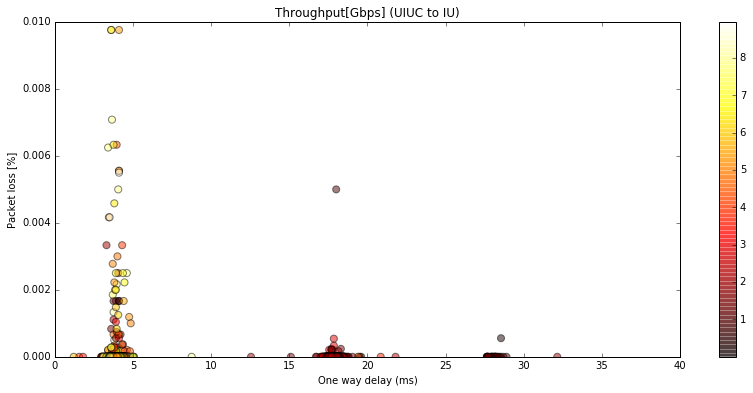

In [17]:
plt.figure(figsize=[14, 6])
plt.scatter(dm, pl, s=50, c=tp, alpha=.5, cmap='hot')
plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Packet loss [%]')
plt.xlim(xmin=0)
plt.ylim(ymin=0,ymax=0.01)
plt.title('Throughput[Gbps] (' + sourceSite + ' to '+ destinationSite + ')')
plt.show()

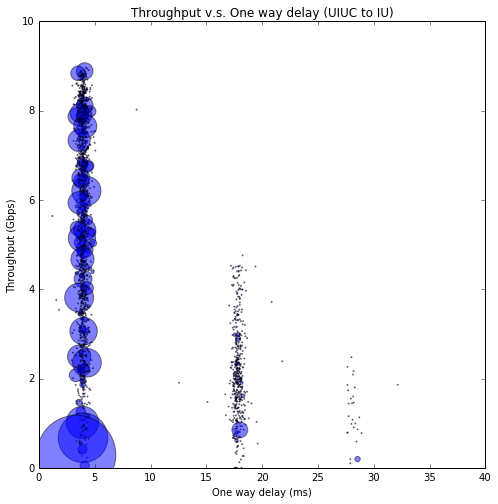

In [19]:
plt.figure(figsize=[8, 8])
plt.scatter(dm, tp, s=pl * 50000 + 1,  alpha=.5) #c=pl*1000,
plt.xlim(xmin=0)
# plt.xlim(xmax=30)
plt.ylim([0,10])
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (Gbps)')
tit='Throughput v.s. One way delay (' + sourceSite + ' to '+ destinationSite + ')'
plt.title(tit)
plt.savefig('Plots/' + tit + '.png')
plt.show()

In [ ]:
plt.figure(figsize=[12, 8])
plt.scatter(dm, tp, s=100, c='#403075')
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (Gbps)')
plt.title('Throughput v.s. One way delay (' + sourceSite + ' to '+ destinationSite + ')')
plt.show()

In [ ]:
a

In [ ]:
a = pd.read_pickle("Data/OneLinkData" + '_' + sourceSite + '-' + destinationSite + ".pkl")

d = a.delay_median
d = d[d.notnull()]

plt.figure(figsize=[12, 8])
plt.xlim(xmin=0,xmax=30)
plt.hist(d, 350, facecolor='green', alpha=0.75)
plt.xlabel('One way delay (ms)'), plt.ylabel('Count')

tit='One way delay median (' + sourceSite + ' to '+ destinationSite + ')'
plt.title(tit)
plt.savefig('Plots/' + tit + '.png')
